# Machine Translation

German-English

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("deu.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:50000,:]

# 3)-Text Pre-Processing

In [8]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

In [9]:
# for english part 
deu_eng[:,0]

array(['Hi.', 'Hi.', 'Run!', ..., 'The man died of cancer.',
       'The man lay motionless.', 'The man must be insane.'],
      dtype='<U537')

In [10]:
# for german part of lang.
deu_eng[:,1]

array(['Hallo!', 'Grüß Gott!', 'Lauf!', ..., 'Der Mann starb an Krebs.',
       'Der Mann lag bewegungslos da.',
       'Der Mann muss geistesgestört sein.'], dtype='<U537')

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

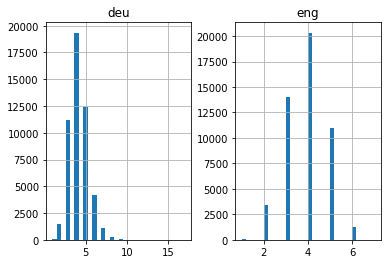

In [12]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 8 and that of the English phrases is 6.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [13]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6352


In [14]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10678


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode German sentences as the input sequences and English sentences as the target sequences

In [17]:
# english version
train[:, 0]

array(['i have some bad news', 'spare me the details',
       'do you know my husband', ..., 'my bag was stolen',
       'tom works long hours', 'i like tom a lot'], dtype='<U537')

In [18]:
# english version
train[:, 1]

array(['ich habe schlechte nachrichten', 'erspare mir die einzelheiten',
       'kennst du meinen mann', ..., 'meine tasche wurde gestohlen',
       'tom hat eine lange arbeitszeit',
       'tom ist mir unglaublich sympathisch'], dtype='<U537')

In [0]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) 

# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [20]:
print(trainX[:5])

[[   1   14  604 1274    0    0    0    0]
 [9062   15   17 3411    0    0    0    0]
 [ 556    8  139  185    0    0    0    0]
 [  22   10    4    0    0    0    0    0]
 [   5    3   24 1429  393    0    0    0]]


In [21]:
print(trainY[:5])

[[   2   19  143  135  481    0    0    0]
 [2670    9    8 2312    0    0    0    0]
 [  11    3   33   16  780    0    0    0]
 [  27  110   26   19    0    0    0    0]
 [  23    5  200  442    0    0    0    0]]


In [22]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(40000, 8)
(40000, 8)
(10000, 8)
(10000, 8)


### 4.3)- build NMT model

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [24]:
# model compilation (with 512 hidden units)
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics = ['accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            5467136   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 6352)           3258576   
Total params: 12,924,112
Trainable params: 12,924,112
Non-trainable params: 0
_________________________________________________________________


In [26]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 21s 660us/step - loss: 3.5472 - acc: 0.5279 - val_loss: 3.0612 - val_acc: 0.5509

Epoch 00001: val_loss improved from inf to 3.06119, saving model to model_translate.h1
Epoch 2/30
32000/32000 [==============================] - 15s 471us/step - loss: 2.8965 - acc: 0.5562 - val_loss: 2.8323 - val_acc: 0.5595

Epoch 00002: val_loss improved from 3.06119 to 2.83227, saving model to model_translate.h1
Epoch 3/30
32000/32000 [==============================] - 15s 471us/step - loss: 2.7236 - acc: 0.5727 - val_loss: 2.6779 - val_acc: 0.5851

Epoch 00003: val_loss improved from 2.83227 to 2.67794, saving model to model_translate.h1
Epoch 4/30
32000/32000 [==============================] - 15s 474us/step - loss: 2.5514 - acc: 0.5942 - val_loss: 2.5502 - val_acc: 0.6002

Epoch 00004: val_loss improved from 2.67794 to 2.55018, saving model to model_translate.h1
Epoch 5/30
32000/32000 [======

# 5)-Plotting results

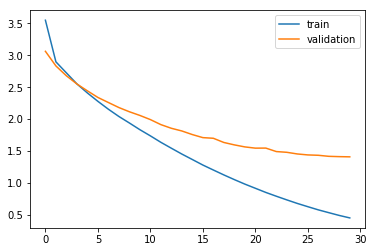

In [27]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 20 epochs.

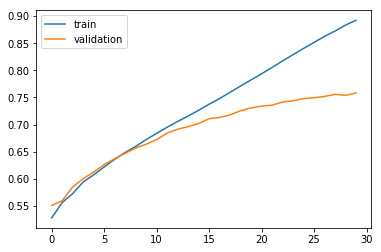

In [28]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.legend(['train','validation']) 
plt.show()

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (English)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], eng_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],eng_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [33]:
# 1st 15 rows
pred_df.head(15)

,actual,predicted
0,he wanted to be rich,he used to be rich
1,i love tom,i love tom
2,let us go home,lets go home
3,i love driving,i love your like
4,this is my dictionary,thats my dictionary
5,hi tom good morning,tell tom
6,why is she so popular,why is she so
7,ill show you my room,ill show you my room
8,did tom oversleep,tom overslept
9,keep up the good work,just a of your work


In [34]:
# print 15 rows randomly 
pred_df.sample(15)

,actual,predicted
4074,hes over forty,he is over forty
190,tom seemed to be done,tom was sick
8572,youll do great,youll do it
6620,tom knows wines,tom knows french
2011,tom is following mary,tom is scolding mary
128,a dog is following us,its a
1113,he can read and write,he can play his
4599,trust tom,ask tom
6881,do you know my father,do you know my father
686,tom disgusts me,tom adores me
